# QOSF Mentorship Assignment


* **Name: Tanya Garg**
* **Task No: 4**

# Introduction:


In the project, we will be finding the lowest eigenvalue of the matrix **H** mentioned below using a variational quantum eigensolver(VQE) algorithm made from scratch. Matrix **H** is given by:

$ H=\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$



In this task, we will be using Qiskit.

In [1]:
#importing required libraries

from qiskit import *
from numpy import *
import matplotlib.pyplot as plt
from scipy import linalg



### The task will broadly follow the following steps:
* Step 1: Formation of the Hamiltonian by decomposing the **H** matrix into the sum of tensor products of Pauli matrices $\Rightarrow$ X, Y, Z, I
* Step 2: Formation of the Ansatz
* Step 3: Calculating and plotting the expectation value of the hamiltonion calculated in Step 1
* Step 4: Finding the minimum eigen value from the plot




## Step 1: Decomposition into Pauli Matrices

The Pauli matrices are represented as:

$ X=\left[ \begin{array}{cc}
0 & 1 \\
1 & 0
\end{array} \right]\hspace{0.2in}
%  
Y=\left[ \begin{array}{cc}
0 & -i \\
i & 0
\end{array} \right]\hspace{0.2in}
%   
Z=\left[ \begin{array}{cc}
1 & 0 \\
0 & -1
\end{array} \right]
$



After decompostion into Pauli Matrices, the matrix **H** will be in the form:

$$H= x X\otimes X + y Y\otimes Y +z Z\otimes Z+ e I\otimes I$$


Let us now compute the values of XX, YY, ZZ and II


In [2]:
#Computing X, Y, Z 
X=array([[0,1],[1,0]])
Y=array([[0,-1j],[1j,0]])
Z=array([[1,0],[0,-1]])

#Computing XX,YY,ZZ,II

XX=kron(X,X)
YY=kron(Y,Y)
ZZ=kron(Z,Z)
II=eye(4)

# YY matrix should be real:
YY=real(YY)

#Displaying the computed matrices
print('XX Matrix:\n',XX)
print('YY Matrix:\n',YY)
print('ZZ Matrix:\n',ZZ)
print('II Matrix:\n',II)


XX Matrix:
 [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
YY Matrix:
 [[ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]]
ZZ Matrix:
 [[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]
II Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Now we will compute the values of $ x,\, y,\, z \, and \,e$:

In [3]:
#Decomposition of H matrix:

H=array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])
t=[]

for i in [XX,YY,ZZ,II]:
    t.append(0.25*(dot(i.conjugate().transpose(),H)).trace())
    
[x,y,z,e]=t

#Displaying the value of x,y,z and e
print(t)

[-0.5, -0.5, 0.5, 0.5]


## Step 2: Formation of the Ansatz

Ansatz is a set of operations on our state which will be able to make it cover the whole vector space. It is a guess/assumption to reach the optimal solution. To optimize the circuit the ansatz should not have a lot of parameters and the circuit should not have a huge number of gates i.e. the circuit should be shallow.

According to the hint given, the ideal ansatz would be: $\left(R_x \otimes I\right)\left(CX\right)\left(H\otimes I\right)$

We will now build the ansatz circuit:

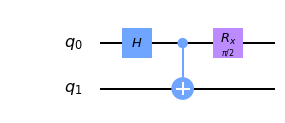

In [4]:
def ansatz(circuit,theta):
    circuit.h(0)
    circuit.cx(0,1)
    circuit.rx(theta,0)
    return circuit

#visualisation of the ansatz circuit

qc=QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.rx(pi/2,0) #the parameter(here pi/2) will vary in the actual implementation
qc.draw('mpl')

## Step 3: Calculation of the expectation value

The expectation value is the probabilistically expected value of the result(measurement) of an experiment. Here, we will calculate the expectation value of **H** with respect to a quantum state $\mid \psi\rangle$ which will be given to us by the ansatz.

The expectation value of the **H** matrix will be given by:


$$\langle H\rangle=\langle\psi\left|H\right|\psi \rangle=x \langle\psi\left|X\otimes X\right|\psi\rangle + y \langle\psi\left|Y\otimes Y\right|\psi\rangle +z \langle\psi\left|Z\otimes Z\right|\psi\rangle+ e \langle\psi\left|I\otimes I\right|\psi\rangle$$


From the above expression we can see that due to the linearity of the quantum state the expectation value of **H** will be equal to the sum of the expectation values of the individual terms.
As all the 'computational measurements' takes place in the Z basis, the calculation of the expectation value of $Z\otimes Z$ will a straightforward one.

$\mid \psi\rangle$ is a 2-qubit quantum state and is thus defined as:


$$\mid \psi\rangle=a\mid00\rangle+b\mid01\rangle+c\mid10\rangle+d\mid11\rangle$$


where the square of the coefficient of each state gives us the probability of obtaining that state on measurement.

When measuring the Z basis, we will have to remember that the expectation value of $\mid0\rangle$ is 1 and the expectation value of $\mid1\rangle$ is -1. Therefore, the expectation value of $Z\otimes Z$ will be:


$$\langle\psi\left|Z\otimes Z\right|\psi\rangle= a^2+d^2-b^2-c^2$$


Therefore, while implementing the VQE algorithm on the Quantum Computer(where probability is given in the form of shots) the probability for each state will be given by:

$$P\left(state\right)=\frac{no. of shots\, for \, that\, state}{Total\, no \,of \,shots}$$

To get the expectation value of the $X\otimes X$ and $Y\otimes Y$  terms, we will convert the Z basis into the X and Y basis respectively which can be done in the following manner:

$$X=HZH$$

$$Y=\left(HS^\dagger\right) ^\dagger Z \left(S^\dagger H\right)$$

where 
$ H=\left[ \begin{array}{cc}
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & \frac{-1}{\sqrt{2}}
\end{array} \right]\hspace{0.2in}
%  
S^\dagger =\left[ \begin{array}{cc}
1 & 0 \\
0 & -i
\end{array} \right]
$

Therefore, the expectation values are given as follows:


$$\langle\psi\left|X\otimes X\right|\psi\rangle= \langle\psi\left|\left(H\otimes H\right)Z\otimes Z\left(H\otimes H\right)\right|\psi\rangle$$


$$\langle\psi\left|Y\otimes Y\right|\psi\rangle= \langle\psi\left|\left(HS^\dagger\otimes HS^\dagger\right)^\dagger Z\otimes Z\left(HS^\dagger\otimes HS^\dagger\right)\right|\psi\rangle$$

We will now compute the expectation values using the above mentioned expressions:




In [5]:
#function to measure the expectation value of ZZ on the 2-qubit state

def ZZ_expectation_value(circuit,shots):
    
    circuit.measure_all()   #measuring all qubits to cbits
    
    backend=Aer.get_backend('qasm_simulator')
    result_zz=execute(circuit,backend=backend,shots=shots).result()
    items=result_zz.get_counts().items()
    counts=0
    
    for key,value in items:
        counts=counts+ (-1)**(int(key[0])+int(key[1]))*value
        
    return counts/shots #expectation value of measurement of ZZ     


#function to measure the expectation value of XX on the 2-qubit state

def XX_expectation_value(circuit,shots):
    
    #changing XX to ZZ basis
    circuit.h(0)
    circuit.h(1)
    
    #Calculating the expectation value
    value=ZZ_expectation_value(circuit,shots)
    return value


#function for measure the expectation value of YY on the 2-qubit state

def YY_expectation_value(circuit,shots):
    
    #changing YY to ZZ basis
    circuit.sdg(0)
    circuit.sdg(1)
    circuit.h(0)
    circuit.h(1)
    
    #Calculating the expectation value
    value=ZZ_expectation_value(circuit,shots)
    return value

                             

Now we will implement the runner code and plot the calculated expectation values of the **H** matrix at different values of theta i.e. at different ansatz.

Text(0.5, 1.0, 'Curve of expectation value vs theta')

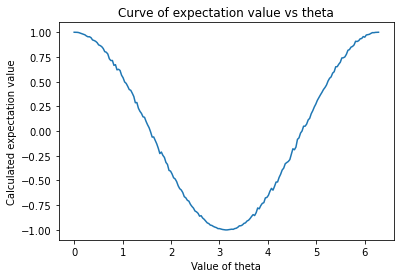

In [6]:

#Initialising the number of shots

shots=2048

#initialising the range of values for theta

theta=linspace(0,2*pi,200)
value=[]
E=0

#Calculating the expectation values of H
for i in theta:
    
    
    #XX component
    circuit_XX = QuantumCircuit(2,2)
    circuit_XX = ansatz(circuit_XX,i)
    E=E+x*XX_expectation_value(circuit_XX,shots)
    
    
    #YY component
    circuit_YY = QuantumCircuit(2,2)
    circuit_YY = ansatz(circuit_YY,i)  
    E=E+y*YY_expectation_value(circuit_YY,shots)
    
    
    #ZZ component
    circuit_ZZ = QuantumCircuit(2,2)
    circuit_ZZ = ansatz(circuit_ZZ,i)
    E=E+z*ZZ_expectation_value(circuit_ZZ,shots)
    
    
    #II component
    E=E+e
    
    
    value.append(E)
    E=0
    
   
#Plotting the calculated expectation values:

plt.plot(theta,value)
plt.xlabel('Value of theta')
plt.ylabel('Calculated expectation value')
plt.title('Curve of expectation value vs theta')

    


## Step 4: Finding the minimum eigen value

We will now find the minimum eigen value of the **H** matrix by the above plot and compare it to the minimum eigen value calculated by an inbuilt function from scipy

In [7]:
#Minimum eigenvalue/expectation value using the plot

min_calc=round(min(value),5)
print('Minimum Eigen value of the H matrix using a quantum computer is :',min_calc)


#Value of theta at the minimum expectation value is obtained

theta_calc=round(theta[value.index(min(value))],4)
print('Value of theta at which the expectation value is minimum: ',theta_calc)


#Minimum eigenvalue/expectation value using the plot

min_theor=linalg.eig(H)                   
min_theor=real(min(min_theor[0])) #real as all the elements in matrix are real
print('\nMinimum eigen value of the H matrix by inbuilt function is: ',min_theor) 

Minimum Eigen value of the H matrix using a quantum computer is : -1.0
Value of theta at which the expectation value is minimum:  3.1258

Minimum eigen value of the H matrix by inbuilt function is:  -1.0
